In [1]:
import gymnasium as gym
import torch as th
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# import EvnOneStock
import EvnSingleStock

import pandas as pd
# import numpy as np
# from datetime import datetime

In [2]:
# 1. 定义自定义特征提取器 和 简单的 mlp_extractor 自定义
class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.layers = nn.Sequential(
            nn.Linear(n_input_channels, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.layers(observations)

# 2. 配置 policy_kwargs
policy_kwargs = dict(
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(features_dim=256),
    # 自定义 mlp_extractor 就在这里：
    # net_arch=dict(
    #     pi=[128, 64],  # 策略网络 (Actor) 的隐藏层：256 -> 128 -> 64
    #     vf=[64, 64]    # 价值网络 (Critic) 的隐藏层：256 -> 64 -> 64
    # )
)

In [19]:
# 3. 创建模型
stock_code = "600118.SH"
stock_daily_pd = pd.read_csv(f"./data_input/{stock_code}.csv", dtype={"trade_date":"str"})
stock_daily_pd["limit"] = stock_daily_pd["limit"].fillna(10000)
stock_daily_pd["stopping"] = stock_daily_pd["stopping"].fillna(0)
train_pd = stock_daily_pd[:6020]
test_pd = stock_daily_pd[6000:]

In [20]:
train_env = EvnSingleStock.StockTradingEnv(train_pd, red_line=-0.5, evn_file="PPO_v2_002_train")
model = PPO("MlpPolicy", train_env, policy_kwargs=policy_kwargs, verbose=0)
model.learn(total_timesteps=1e5)

D:\pyvenv\rl\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [21]:
model.save("./model/PPO_v2_002")

In [22]:
test_env = EvnSingleStock.StockTradingEnv(test_pd, red_line=-0.5, evn_file=f"PPO_v2_002_test_{stock_code}")

# 2. 进行推理（预测）
obs, info = test_env.reset()
while True:
    # predict 函数返回两个值：action 和 _states（对于非循环策略，_states 通常为 None）
    # deterministic=True 建议在推理阶段开启，以获得稳定的表现
    action, _states = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_env.step(action)

    if terminated or truncated:
        break

In [7]:
test_pd = pd.read_csv("./env_log/PPO_v2_test_20260115_155449.csv")
train_pd = pd.read_csv("./env_log/PPO_v2_train_20260115_153811.csv")

In [11]:
test_pd["dt"] = pd.to_datetime(test_pd["date"], format="%Y%m%d")
test_pd

,date,target_position,actual_position,adj_old_position,adj_open,adj_close,adj_preclose,high,low,limit_price,...,tradestatuscode,daily_return,current_net_worth,max_net_worth,mdd,total_return,reward,terminated,truncated,dt
0,20220711,0.362660,0.362660,0.000000,337.4300,330.8600,337.4300,20.06,19.52,22.01,...,-1,-0.007061,9.929388e+05,1.000000e+06,-0.007061,-0.007061,-0.021184,False,False,2022-07-11
1,20220712,0.356926,0.356926,0.358128,330.8600,328.3300,330.8600,20.01,19.23,21.58,...,-1,-0.002729,9.902287e+05,1.000000e+06,-0.009771,-0.009771,-0.029314,False,False,2022-07-12
2,20220713,0.357501,0.357501,0.355166,328.3300,323.7700,328.3300,19.59,19.11,21.42,...,-1,-0.004965,9.853121e+05,1.000000e+06,-0.014688,-0.014688,-0.044064,False,False,2022-07-13
3,20220714,0.352007,0.352007,0.354295,323.6000,325.9700,323.7700,19.45,19.13,21.12,...,-1,0.002392,9.876685e+05,1.000000e+06,-0.012331,-0.012331,-0.036994,False,False,2022-07-14
4,20220715,0.352421,0.352421,0.353673,326.1300,322.2600,325.9700,19.45,19.11,21.26,...,-1,-0.004009,9.837088e+05,1.000000e+06,-0.016291,-0.016291,-0.048874,False,False,2022-07-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,20260107,0.371283,0.371283,0.394370,1745.3105,1698.3735,1813.2590,103.65,99.00,117.71,...,-1,-0.024616,1.933504e+06,1.982300e+06,-0.024616,0.933504,0.884272,False,False,2026-01-07
849,20260108,0.371790,0.371790,0.364942,1677.5314,1728.3657,1698.3735,106.39,97.45,110.25,...,-1,0.006737,1.946531e+06,1.982300e+06,-0.018044,0.946531,0.910442,False,False,2026-01-08
850,20260109,0.372017,0.372017,0.378789,1758.5274,1796.9920,1728.3657,109.00,101.00,112.20,...,-1,0.014801,1.975342e+06,1.982300e+06,-0.003510,0.975342,0.968322,False,False,2026-01-09
851,20260112,0.370908,0.370908,0.377086,1897.8133,1976.7759,1796.9920,116.66,110.00,116.66,...,-1,0.036916,2.048262e+06,2.048262e+06,0.000000,1.048262,1.048262,False,False,2026-01-12


<Axes: >

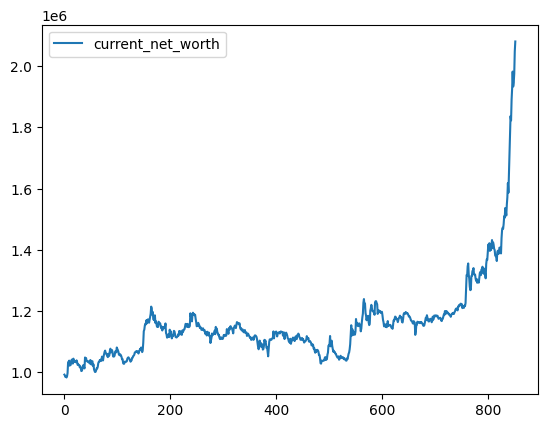

In [13]:
test_pd[["current_net_worth"]].plot()

<Axes: >

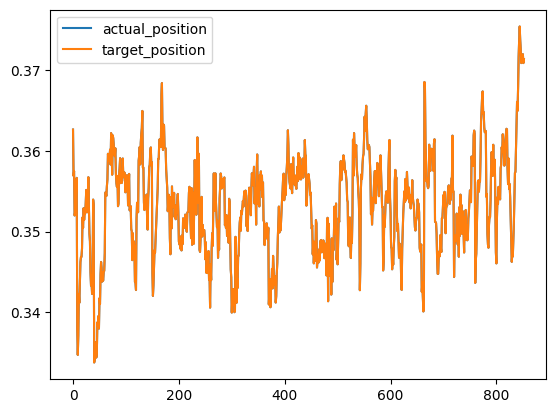

In [14]:
test_pd[["actual_position","target_position"]].plot()